In [157]:
from Izh_net import *
from net_preparation import *
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg' 
from tqdm import tqdm
import numpy as np
from scipy.signal import correlate
from scipy.fft import fft

# Running procedure
def run(net, T, Iapp):
    net.set_init_conditions(v_noise=np.array([-5, 5]))
    dt = T[1] - T[0]
    N = len(net)
    V = np.zeros((len(T), N))
    for i, t in enumerate(T):
        V[i] = net.V_prev
        net.step(dt=dt, Iapp=Iapp(t))
    return V

def calc_T(bursts):    
    dists = np.diff(bursts[:, 0])
    return np.mean(dists), np.std(dists)

def calc_df(bursts1, bursts2):
    # Calc aver periods
    period1, _ = calc_T(bursts1)
    period2, _ = calc_T(bursts2)
    period = period1/2 + period2/2
    
    max_id = min(len(bursts1), len(bursts2))

    # time delay
    dt = bursts1[:max_id, 0] - bursts2[:max_id, 0]
    # phase difference
    phase_difference = 2 * np.pi * np.mean(dt)/period  # Умножаем на частоту сигнала
    phase_std =  2 * np.pi * np.std(dt)/period
    return abs(phase_difference), phase_std

def draw_bursts(brusts):
    for x in brusts:
        plt.axvline(x = x[0], ymin=0, ymax=1, color='red', linewidth=0.5)
        plt.axvline(x = x[1], ymin=0, ymax=1, color='blue', linewidth=0.5)
    return None

Рассмотрим систему из полуцентрового генератора ритма.
Варируя параметры синаптической связи получим зависимость разности фаз пачечной активности на полуцентрах.

In [169]:
from scipy.signal import correlate
# Creating network
# Creating network
N = 2
A = np.array([0.004, 0.004])
B = np.array([0.46, 0.46])
C = np.array([-45.1, -45])
D = np.array([2, 2])
net = Izhikevich_Network(N=N, a=A, b=B, c=C, d=D)
net.names=["RG_f", "RG_e"]
net.M = np.array([
            [0, 1],
            [1, 0],
        ])
    
I = np.zeros(N)
I[0] = 0.1
I[1] = 0
input = lambda t: I + np.random.normal(size=N)
# prepare simulations
T_max = 20000
time_scale = 3
T = np.linspace(0, T_max, T_max*time_scale)
dt = T[1]-T[0]

# Set the random seed for reproducibility
np.random.seed(2000)

# Number of simulations
num_simulations = 1

# Define the parameter sets for each Q
# Define the parameter sets for each Q
w_values =  np.linspace(0.1, 5, 5)
tau_values = np.linspace(0.5, 25, 200)


# Accumulate results
Max_proc = len(tau_values)*len(w_values)
DF_mean = np.zeros((len(w_values),len(tau_values)))
DF_std = np.zeros_like(DF_mean)
with tqdm(total=Max_proc) as pbar:
    for II, w in enumerate(w_values):
        for K, tau in enumerate(tau_values):
            net.set_weights(np.array([
                        [0, -w],
                        [-w, 0],
                    ])
                    )
            
            net.set_synaptic_relax_constant(
                        np.array(
                        [
                            [1, tau],
                            [tau, 1],
                        ]
                        )
                    )
            V = run(net, T, input)
            
            # build rastr
            maskT = T>5000
            firing_rastr = create_firing_rastr(V[maskT], T[maskT], 30)
            
            #bursting for RG_F
            mask1 = np.where(firing_rastr[1]==0)
            bursts1 = get_bursts_regions(find_bursts(firing_rastr[0][mask1], T_max))
            #bursting for RG_F
            mask2 = np.where(firing_rastr[1]==1)
            bursts2 = get_bursts_regions(find_bursts(firing_rastr[0][mask2], T_max))
            df = calc_df(bursts1, bursts2)
            DF_mean[II, K] = df[0]
            DF_std[II, K] = df[1]
            #print(f'df = {df[0]:.2f} pm {df[1]} ')
            # Visualization
            #plt.figure(figsize=(12, 3))
            #plt.subplot(121)
            #for i in range(N):
            #    plt.plot(T[maskT], V[:, i][maskT], label=f"{net.names[i]}")
            #draw_bursts(bursts1)
            #draw_bursts(bursts2)
            #plt.xlabel('Time (ms)')
            #plt.ylabel('Membrane Potential (mV)')
            #plt.title(f'Average Membrane Potential of Neurons w1 = {w}, tau = {tau}')
            #plt.legend()
            #plt.subplot(1, 2, 2)
            #plt.scatter(firing_rastr[0], firing_rastr[1], s=0.5)
            #draw_bursts(bursts1)
            #draw_bursts(bursts2)
            #plt.yticks(list(range(net.N)), net.names)
            #plt.tight_layout()
            #plt.show()
            pbar.update(1)

100%|███████████████████████████████████████| 1000/1000 [14:48<00:00,  1.13it/s]


In [164]:
from scipy.optimize import curve_fit
# Определяем сигмоидальную функцию
def sigmoid(x, A, k, x0, C):
    return A / (1 + np.exp(-k * (x - x0))) + C

DF_mean_norm = np.where(DF_mean <= np.pi, DF_mean, 2*np.pi - DF_mean)
i = 4
print(w_values[i])
print(len(DF_mean_norm[i, np.isnan(DF_mean_norm[i])]))
print(tau_values[np.isnan(DF_mean_norm[i])])

5.0
0
[]


In [165]:
from ipywidgets import interact
def var(w_id=0):
    #filter nan values
    mask = ~np.isnan(DF_mean_norm[w_id])
    plt.figure()
    plt.title(f"w={w_values[w_id]:.3f}")
    plt.errorbar(tau_values[mask], DF_mean_norm[w_id, mask], yerr=DF_std[w_id, mask], fmt='.', c='k', ecolor='r')
    # fit data use sigmoidal function
    params, _ = curve_fit(sigmoid, tau_values[mask], DF_mean_norm[w_id, mask], p0=[np.pi/2, 1, 0, np.pi/2])
    plt.plot(tau_values, sigmoid(tau_values, *params), color='orange',
             label=rf"fit = {params[0]:.2f}/exp[{-params[1]:.2f}*($\tau$-{params[2]:.2f})] + {params[3]:.2f}")
    plt.axhline(np.pi, color='blue', label='antiphase')
    plt.legend()
    plt.xlabel(r'$\tau$, ms')
    plt.ylabel(r"$\Delta\Phi$, radians")
    plt.minorticks_on()
    plt.show()
    return None
interact(var, w_id=np.arange(len(w_values)))

interactive(children=(Dropdown(description='w_id', options=(np.int64(0), np.int64(1), np.int64(2), np.int64(3)…

<function __main__.var(w_id=0)>

/tmp/ipykernel_637722/383040261.py:4: RuntimeWarning: overflow encountered in exp
  return A / (1 + np.exp(-k * (x - x0))) + C


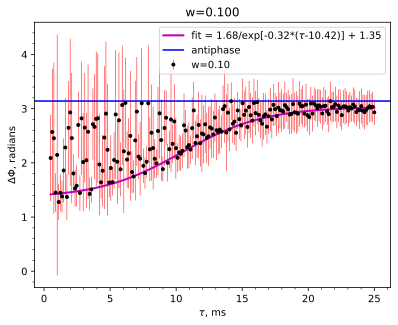

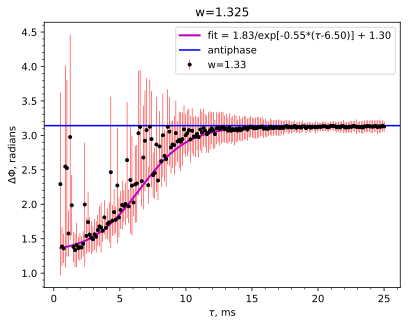

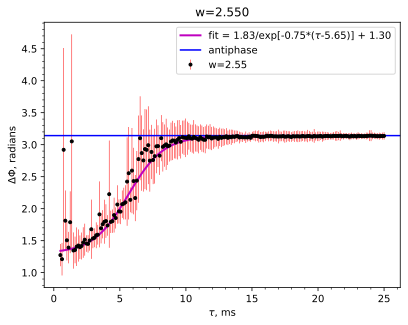

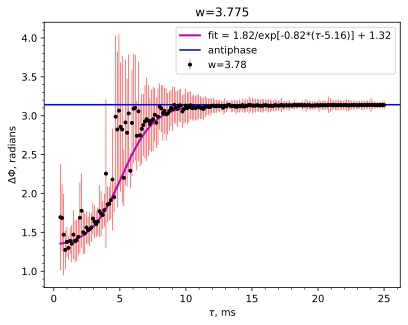

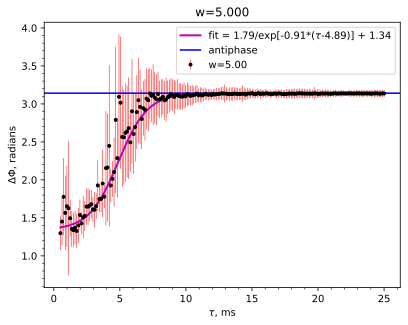

In [168]:
for w_id in range(len(w_values)):
    #filter nan values
    mask1 = ~np.isnan(DF_mean_norm[w_id])
    mask2 = DF_std[w_id]<=0.3 
    mask = np.logical_and(mask1, mask2)
    plt.figure()
    plt.title(f"w={w_values[w_id]:.3f}")
    plt.errorbar(tau_values, DF_mean_norm[w_id], yerr=DF_std[w_id], fmt='.', c='k', ecolor='r',
                 elinewidth=0.5, label=f"w={w_values[w_id]:.2f}")
    params, _ = curve_fit(sigmoid, tau_values[mask], DF_mean_norm[w_id, mask], p0=[np.pi/2, 1, 0, np.pi/2])
    plt.plot(tau_values, sigmoid(tau_values, *params), color='m', linewidth=2,
             label=rf"fit = {params[0]:.2f}/exp[{-params[1]:.2f}*($\tau$-{params[2]:.2f})] + {params[3]:.2f}")
    plt.axhline(np.pi, color='blue', label='antiphase')
    plt.legend()
    plt.xlabel(r'$\tau$, ms')
    plt.ylabel(r"$\Delta\Phi$, radians")
    plt.minorticks_on()
    #                   plt.savefig(f'half-center-dphase_from_synaps_w_{w_values[w_id]:.2f}.svg')
    plt.show()
